# Models

In [31]:
import re
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

### 1. Load the data

In [78]:
SAVE_PATH = '../data/our_data/'
filename = 'commits_violations_8.pkl'
df = pd.read_pickle(SAVE_PATH + filename)
df = df.drop(['projectID', 'commitHash', 'blockerViolations','class', 'mimaViolations', 
          'criticalViolations', 'majorViolations', 'minorViolations', 'violations','complexity',
          'bin_criticalViolations', 'bin_blockerViolations', 'bin_mimaViolations', 'bugs', 'codeSmells',
          'class_blockerViolations', 'class_criticalViolations', 'class_mimaViolations'
         ], axis = 1)
df.head()

,commitMessage,lines,commentLines,duplicatedLines,category
0,ACCUMULO-1 initial checkin of source code\n\ng...,263680,13509,46445,7
1,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",262753,13507,46301,7
2,ACCUMULO-2 fixed thrift build script to point ...,262753,13507,46301,7
3,ACCUMULO-2 reverted change to config.html\n\ng...,263643,13507,46445,7
4,ACCUMULO-2 fixed cloudtrace references in cont...,263639,13507,46445,7


### 2. Processing of Commit Message

#### Cleaning of the Commit message

In [79]:
def escape_special_chars(s):
    """
    Escape special characters in a string.
    """
    s = s.replace('(', '\(').replace(')', '\)')
    s = s.replace('+', '\+').replace('?', '\?').replace('*', '\*')
    s = s.replace('[', '\[').replace(']', '\]')
    s = s.replace('{', '\{').replace('}', '\}')
    
    return s

In [80]:
def clean_word(word):
    """
    Returns the longest prefix of a word made of latin unicode
       characters.
    """
    for i, c in enumerate(word):
        if not unicodedata.name(c).startswith("LATIN"):
            return word[:i].lower()
    return word.lower()


def clean_words(words):
    """
    Cleans all words in a string.
    """
    return " ".join(map(clean_word, words.split()))

In [81]:
def clean(s):
    """
    Cleans the commit message according to some rule.
    """
    s = s.lower() # Lower the message
    s = s.strip().replace('\n', '') # Delete break lines 
    s = s.strip().replace('->', 'to') # Change arrows to conjuntction
    # Substitute all non-alphanumeric, spaces, colons and hyphens by empty space
    s = re.sub(r'[^A-Za-z0-9\s:\-]+', ' ', s) 
    # Change numbers by word "num"
    s = re.sub(r'pr[0-9]+:', 'pr num', s)
    s = re.sub(r'[0-9]+', 'num', s)
    s = ' '.join(s.split())
    
    project_name_reg = re.compile('[^\s]*')
    project_name = re.match(project_name_reg, s)
    
    # Define patterns which we want to remove
    patterns = ['git-svn-id:','author:','reviewers:','http','obtained from:','submitted by:','reviewed by:']
    traces_reg = [re.compile(f'{i}.*') for i in patterns]
    
    # Remove project name
    if project_name != None: 
        reg = project_name.group()
        reg = escape_special_chars(reg)
        s = re.sub(f'{reg}', '', s)
    
    # Remove patterns
    for r in traces_reg:
        traces = re.search(r, s)
        if traces != None: 
            reg = traces.group()
            reg = escape_special_chars(reg)
            s = re.sub(f'{reg}', '', s)
    
    # Final clean up
    s = s.strip().replace('-', '')
    s = ' '.join(s.split())
        
    return s

In [82]:
df['commitMessageClean'] = df['commitMessage'].apply(lambda x: clean(x))

In [83]:
print(df.shape)
df = df.drop_duplicates().copy()
print(df.shape)

(55629, 6)
(55622, 6)


In [84]:
# Check the number of unique commit messages
df['commitMessageClean'].nunique() / df['commitMessageClean'].count() * 100

77.27697673582395

#### Vectorizing the Commit message

In [85]:
# Tf - Idf Vectorizer
tf_idf = TfidfVectorizer(min_df = 20, 
                         max_df = 0.5, 
                         ngram_range = (1, 3), 
                         max_features = 1000, 
                         stop_words = 'english'
                        )
print(tf_idf)

TfidfVectorizer(max_df=0.5, max_features=1000, min_df=20, ngram_range=(1, 3),
                stop_words='english')


In [86]:
tf_idf_features = tf_idf.fit_transform(df['commitMessageClean'])
print(tf_idf_features.toarray())
tf_idf_df = pd.DataFrame(tf_idf_features.toarray(), columns = tf_idf.get_feature_names())
tf_idf_df.head()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,ability,able,abstract,access,account,accumulo,accumulonum,action,active,actual,...,xalan,xerces,xml,xmlconfiguration,xpath,xsp,yang,year,yusaku,zookeeper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Add the new features to original table

In [87]:
df = df.drop(['commitMessage','commitMessageClean'], axis = 1)
df = pd.concat((df, tf_idf_df), axis = 1).dropna()
Y = df['category']
X = df.drop(['category'], axis = 1)
print(Y.shape, X.shape)
X.head()

(55615,) (55615, 1003)


,lines,commentLines,duplicatedLines,ability,able,abstract,access,account,accumulo,accumulonum,...,xalan,xerces,xml,xmlconfiguration,xpath,xsp,yang,year,yusaku,zookeeper
0,263680.0,13509.0,46445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,262753.0,13507.0,46301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,262753.0,13507.0,46301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,263643.0,13507.0,46445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,263639.0,13507.0,46445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Train models

#### Split into train and test sets

In [26]:
seed = 123
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state = seed)

In [27]:
X_train.shape, Y_train.shape

((33369, 1003), (33369,))

#### Initial training

In [28]:
classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]
    #XGBClassifier(),
    #AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis()]

In [30]:
log_cols = ["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns = log_cols)

for clf in classifiers:
    clf.fit(X_train, Y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(Y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(Y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    #log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 99.3752%
Log Loss: 0.09172229452063448
DecisionTreeClassifier
****Results****
Accuracy: 98.6964%
Log Loss: 0.45024926523980036
RandomForestClassifier
****Results****
Accuracy: 97.1276%
Log Loss: 0.21853155626818904


#### Cross Validation with k Nearest Neighbors

In [50]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y)

maxk, cv = 20, 3

modelos = []
nombres = [str(k) + ' depth DecisionTreeClassifer' for k in range(1, maxk + 1)]
nombres.append('Complete DecisionTreeClassifer')
for k in range(1, maxk + 1): modelos.append(DecisionTreeClassifier(max_depth = k))
modelos.append(DecisionTreeClassifier())
    
resultados_train_acc = []
resultados_train_loss = []
    
for nombre, modelo in zip(nombres, modelos):
    print(nombre)
    #rkf = RepeatedKFold(n_splits = cv, n_repeats = 3, random_state = 123)
    resultados_nk_acc = []
    resultados_nk_loss = []
    
    #for train_index, test_index in rkf.split(X):
    #    Xc_train_nk, Xc_test_nk = X.values[train_index], X.values[test_index]
    #    Yc_train_nk, Yc_test_nk = Y.values[train_index], Y.values[test_index]
        
    scores_train_acc = cross_val_score(modelo, X, Y, cv = cv, scoring = 'accuracy')
    resultados_nk_acc.append(scores_train_acc.mean())

    scores_train_loss = -cross_val_score(modelo, X, Y, cv = cv, scoring = 'neg_log_loss')
    resultados_nk_loss.append(scores_train_loss.mean())
            
    resultados_train_acc.append(resultados_nk_acc)
    resultados_train_loss.append(resultados_nk_loss)
    print("%s: %f (%f)" % (nombre, np.mean(resultados_nk_acc), np.std(resultados_nk_acc)))
    print("%s: %f (%f)" % (nombre, np.mean(resultados_nk_loss), np.std(resultados_nk_loss)))
    print()

1 depth DecisionTreeClassifer
1 depth DecisionTreeClassifer: 0.400018 (0.000000)
1 depth DecisionTreeClassifer: 2.022403 (0.000000)

2 depth DecisionTreeClassifer
2 depth DecisionTreeClassifer: 0.475825 (0.000000)
2 depth DecisionTreeClassifer: 1.720104 (0.000000)

3 depth DecisionTreeClassifer
3 depth DecisionTreeClassifer: 0.522737 (0.000000)
3 depth DecisionTreeClassifer: 1.468560 (0.000000)

4 depth DecisionTreeClassifer
4 depth DecisionTreeClassifer: 0.605430 (0.000000)
4 depth DecisionTreeClassifer: 1.204724 (0.000000)

5 depth DecisionTreeClassifer
5 depth DecisionTreeClassifer: 0.681093 (0.000000)
5 depth DecisionTreeClassifer: 1.005807 (0.000000)

6 depth DecisionTreeClassifer
6 depth DecisionTreeClassifer: 0.736690 (0.000000)
6 depth DecisionTreeClassifer: 0.784045 (0.000000)

7 depth DecisionTreeClassifer
7 depth DecisionTreeClassifer: 0.772076 (0.000000)
7 depth DecisionTreeClassifer: 0.645413 (0.000000)

8 depth DecisionTreeClassifer
8 depth DecisionTreeClassifer: 0.830423

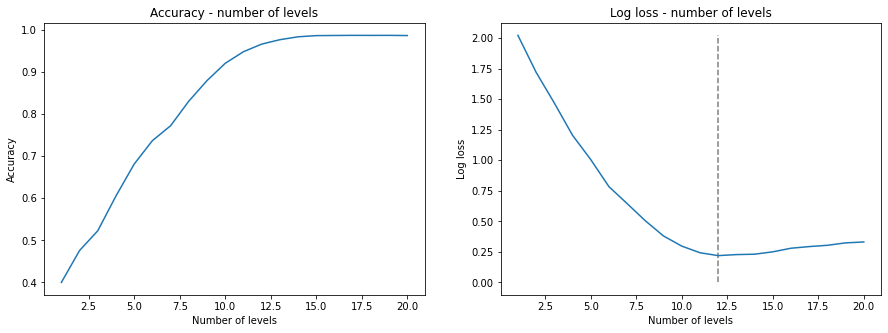

In [69]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].plot(range(1, maxk + 1),resultados_train_acc[:-1])
ax[0].set_xlabel('Number of levels')
ax[0].set_title('Accuracy - number of levels')
ax[0].set_ylabel('Accuracy')
ax[1].plot(range(1, maxk + 1),resultados_train_loss[:-1])
ax[1].set_title('Log loss - number of levels')
ax[1].set_xlabel('Number of levels')
ax[1].set_ylabel('Log loss')
ax[1].vlines(np.argmin(resultados_train_loss[:-1]) + 1, 0, 
          np.max(resultados_train_loss[:-1]),  
          color = 'gray', linestyle = 'dashed')
plt.show()

In [54]:
maxk, cv = 20, 3

modelos_2 = []
nombres_2 = [str(k) + ' depth RandomForestClassifier' for k in range(1, maxk + 1)]
nombres_2.append('Complete RandomForestClassifier')
for k in range(1, maxk + 1): modelos_2.append(RandomForestClassifier(max_depth = k))
modelos_2.append(DecisionTreeClassifier())
    
resultados_train_acc_2 = []
resultados_train_loss_2 = []
    
for nombre, modelo in zip(nombres_2, modelos_2):
    print(nombre)
    #rkf = RepeatedKFold(n_splits = cv, n_repeats = 3, random_state = 123)
    resultados_nk_acc = []
    resultados_nk_loss = []
    
    #for train_index, test_index in rkf.split(X):
    #    Xc_train_nk, Xc_test_nk = X.values[train_index], X.values[test_index]
    #    Yc_train_nk, Yc_test_nk = Y.values[train_index], Y.values[test_index]
        
    scores_train_acc = cross_val_score(modelo, X, Y, cv = cv, scoring = 'accuracy')
    resultados_nk_acc.append(scores_train_acc.mean())

    scores_train_loss = -cross_val_score(modelo, X, Y, cv = cv, scoring = 'neg_log_loss')
    resultados_nk_loss.append(scores_train_loss.mean())
            
    resultados_train_acc_2.append(resultados_nk_acc)
    resultados_train_loss_2.append(resultados_nk_loss)
    print("%s: %f (%f)" % (nombre, np.mean(resultados_nk_acc), np.std(resultados_nk_acc)))
    print("%s: %f (%f)" % (nombre, np.mean(resultados_nk_loss), np.std(resultados_nk_loss)))
    print()

1 depth RandomForestClassifier
1 depth RandomForestClassifier: 0.231071 (0.000000)
1 depth RandomForestClassifier: 2.441374 (0.000000)

2 depth RandomForestClassifier
2 depth RandomForestClassifier: 0.303984 (0.000000)
2 depth RandomForestClassifier: 2.386817 (0.000000)

3 depth RandomForestClassifier
3 depth RandomForestClassifier: 0.404280 (0.000000)
3 depth RandomForestClassifier: 2.307639 (0.000000)

4 depth RandomForestClassifier
4 depth RandomForestClassifier: 0.417819 (0.000000)
4 depth RandomForestClassifier: 2.259954 (0.000000)

5 depth RandomForestClassifier
5 depth RandomForestClassifier: 0.419887 (0.000000)
5 depth RandomForestClassifier: 2.202676 (0.000000)

6 depth RandomForestClassifier
6 depth RandomForestClassifier: 0.425587 (0.000000)
6 depth RandomForestClassifier: 2.145529 (0.000000)

7 depth RandomForestClassifier
7 depth RandomForestClassifier: 0.431035 (0.000000)
7 depth RandomForestClassifier: 2.100346 (0.000000)

8 depth RandomForestClassifier
8 depth RandomFor

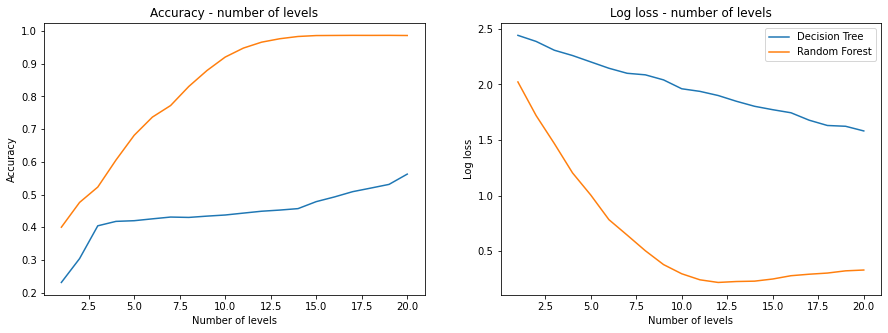

In [71]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].plot(range(1, maxk + 1),resultados_train_acc_2[:-1], label = 'Decision Tree')
ax[0].plot(range(1, maxk + 1),resultados_train_acc[:-1], label = 'Random Forest')
ax[0].set_xlabel('Number of levels')
ax[0].set_title('Accuracy - number of levels')
ax[0].set_ylabel('Accuracy')
ax[1].plot(range(1, maxk + 1),resultados_train_loss_2[:-1], label = 'Decision Tree')
ax[1].plot(range(1, maxk + 1),resultados_train_loss[:-1], label = 'Random Forest')
ax[1].set_title('Log loss - number of levels')
ax[1].set_xlabel('Number of levels')
ax[1].set_ylabel('Log loss')
plt.legend()
plt.show()

In [58]:

list(range(100, 1100, 100))

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [60]:
modelos_3 = []
nombres_3 = [str(k) + ' estimators RandomForestClassifier' for k in range(100, 1100, 100)]
for k in range(100, 1100, 100): modelos_3.append(RandomForestClassifier(n_estimators = k, max_depth = 12))
    
resultados_train_acc_3 = []
resultados_train_loss_3 = []
    
for nombre, modelo in zip(nombres_3, modelos_3):
    print(nombre)
    resultados_nk_acc = []
    resultados_nk_loss = []
        
    scores_train_acc = cross_val_score(modelo, X, Y, cv = cv, scoring = 'accuracy')
    resultados_nk_acc.append(scores_train_acc.mean())

    scores_train_loss = -cross_val_score(modelo, X, Y, cv = cv, scoring = 'neg_log_loss')
    resultados_nk_loss.append(scores_train_loss.mean())
            
    resultados_train_acc_3.append(resultados_nk_acc)
    resultados_train_loss_3.append(resultados_nk_loss)
    print("%s: %f (%f)" % (nombre, np.mean(resultados_nk_acc), np.std(resultados_nk_acc)))
    print("%s: %f (%f)" % (nombre, np.mean(resultados_nk_loss), np.std(resultados_nk_loss)))
    print()

100 estimators RandomForestClassifier
100 estimators RandomForestClassifier: 0.451659 (0.000000)
100 estimators RandomForestClassifier: 1.931496 (0.000000)

200 estimators RandomForestClassifier
200 estimators RandomForestClassifier: 0.447631 (0.000000)
200 estimators RandomForestClassifier: 1.892304 (0.000000)

300 estimators RandomForestClassifier
300 estimators RandomForestClassifier: 0.448278 (0.000000)
300 estimators RandomForestClassifier: 1.900083 (0.000000)

400 estimators RandomForestClassifier
400 estimators RandomForestClassifier: 0.449141 (0.000000)
400 estimators RandomForestClassifier: 1.880231 (0.000000)

500 estimators RandomForestClassifier
500 estimators RandomForestClassifier: 0.446606 (0.000000)
500 estimators RandomForestClassifier: 1.893229 (0.000000)

600 estimators RandomForestClassifier
600 estimators RandomForestClassifier: 0.448548 (0.000000)
600 estimators RandomForestClassifier: 1.904124 (0.000000)

700 estimators RandomForestClassifier
700 estimators Rando

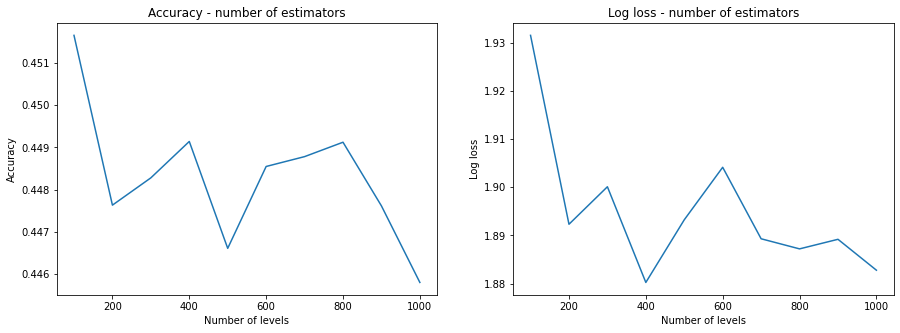

In [64]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].plot(range(100, 1100, 100),resultados_train_acc_3)
ax[0].set_xlabel('Number of levels')
ax[0].set_title('Accuracy - number of estimators')
ax[0].set_ylabel('Accuracy')
ax[1].plot(range(100, 1100, 100),resultados_train_loss_3)
ax[1].set_title('Log loss - number of estimators')
ax[1].set_xlabel('Number of levels')
ax[1].set_ylabel('Log loss')
plt.show()

97.91123497857292
96.89382360873864
[[7463   59   24    0   24    1    8    0]
 [   7  961   21    1    0    2    0    2]
 [  51    0 1118    0    3    0    2   47]
 [   0    1    3 1403    0    1    0   50]
 [ 138    4    0    0 1398   16    1    0]
 [   5    3   19    1    5 1031    0   11]
 [  44   23    0    0   12    0  725   65]
 [   1    0    0   36    0    0    0 7456]]
0.9689382360873865


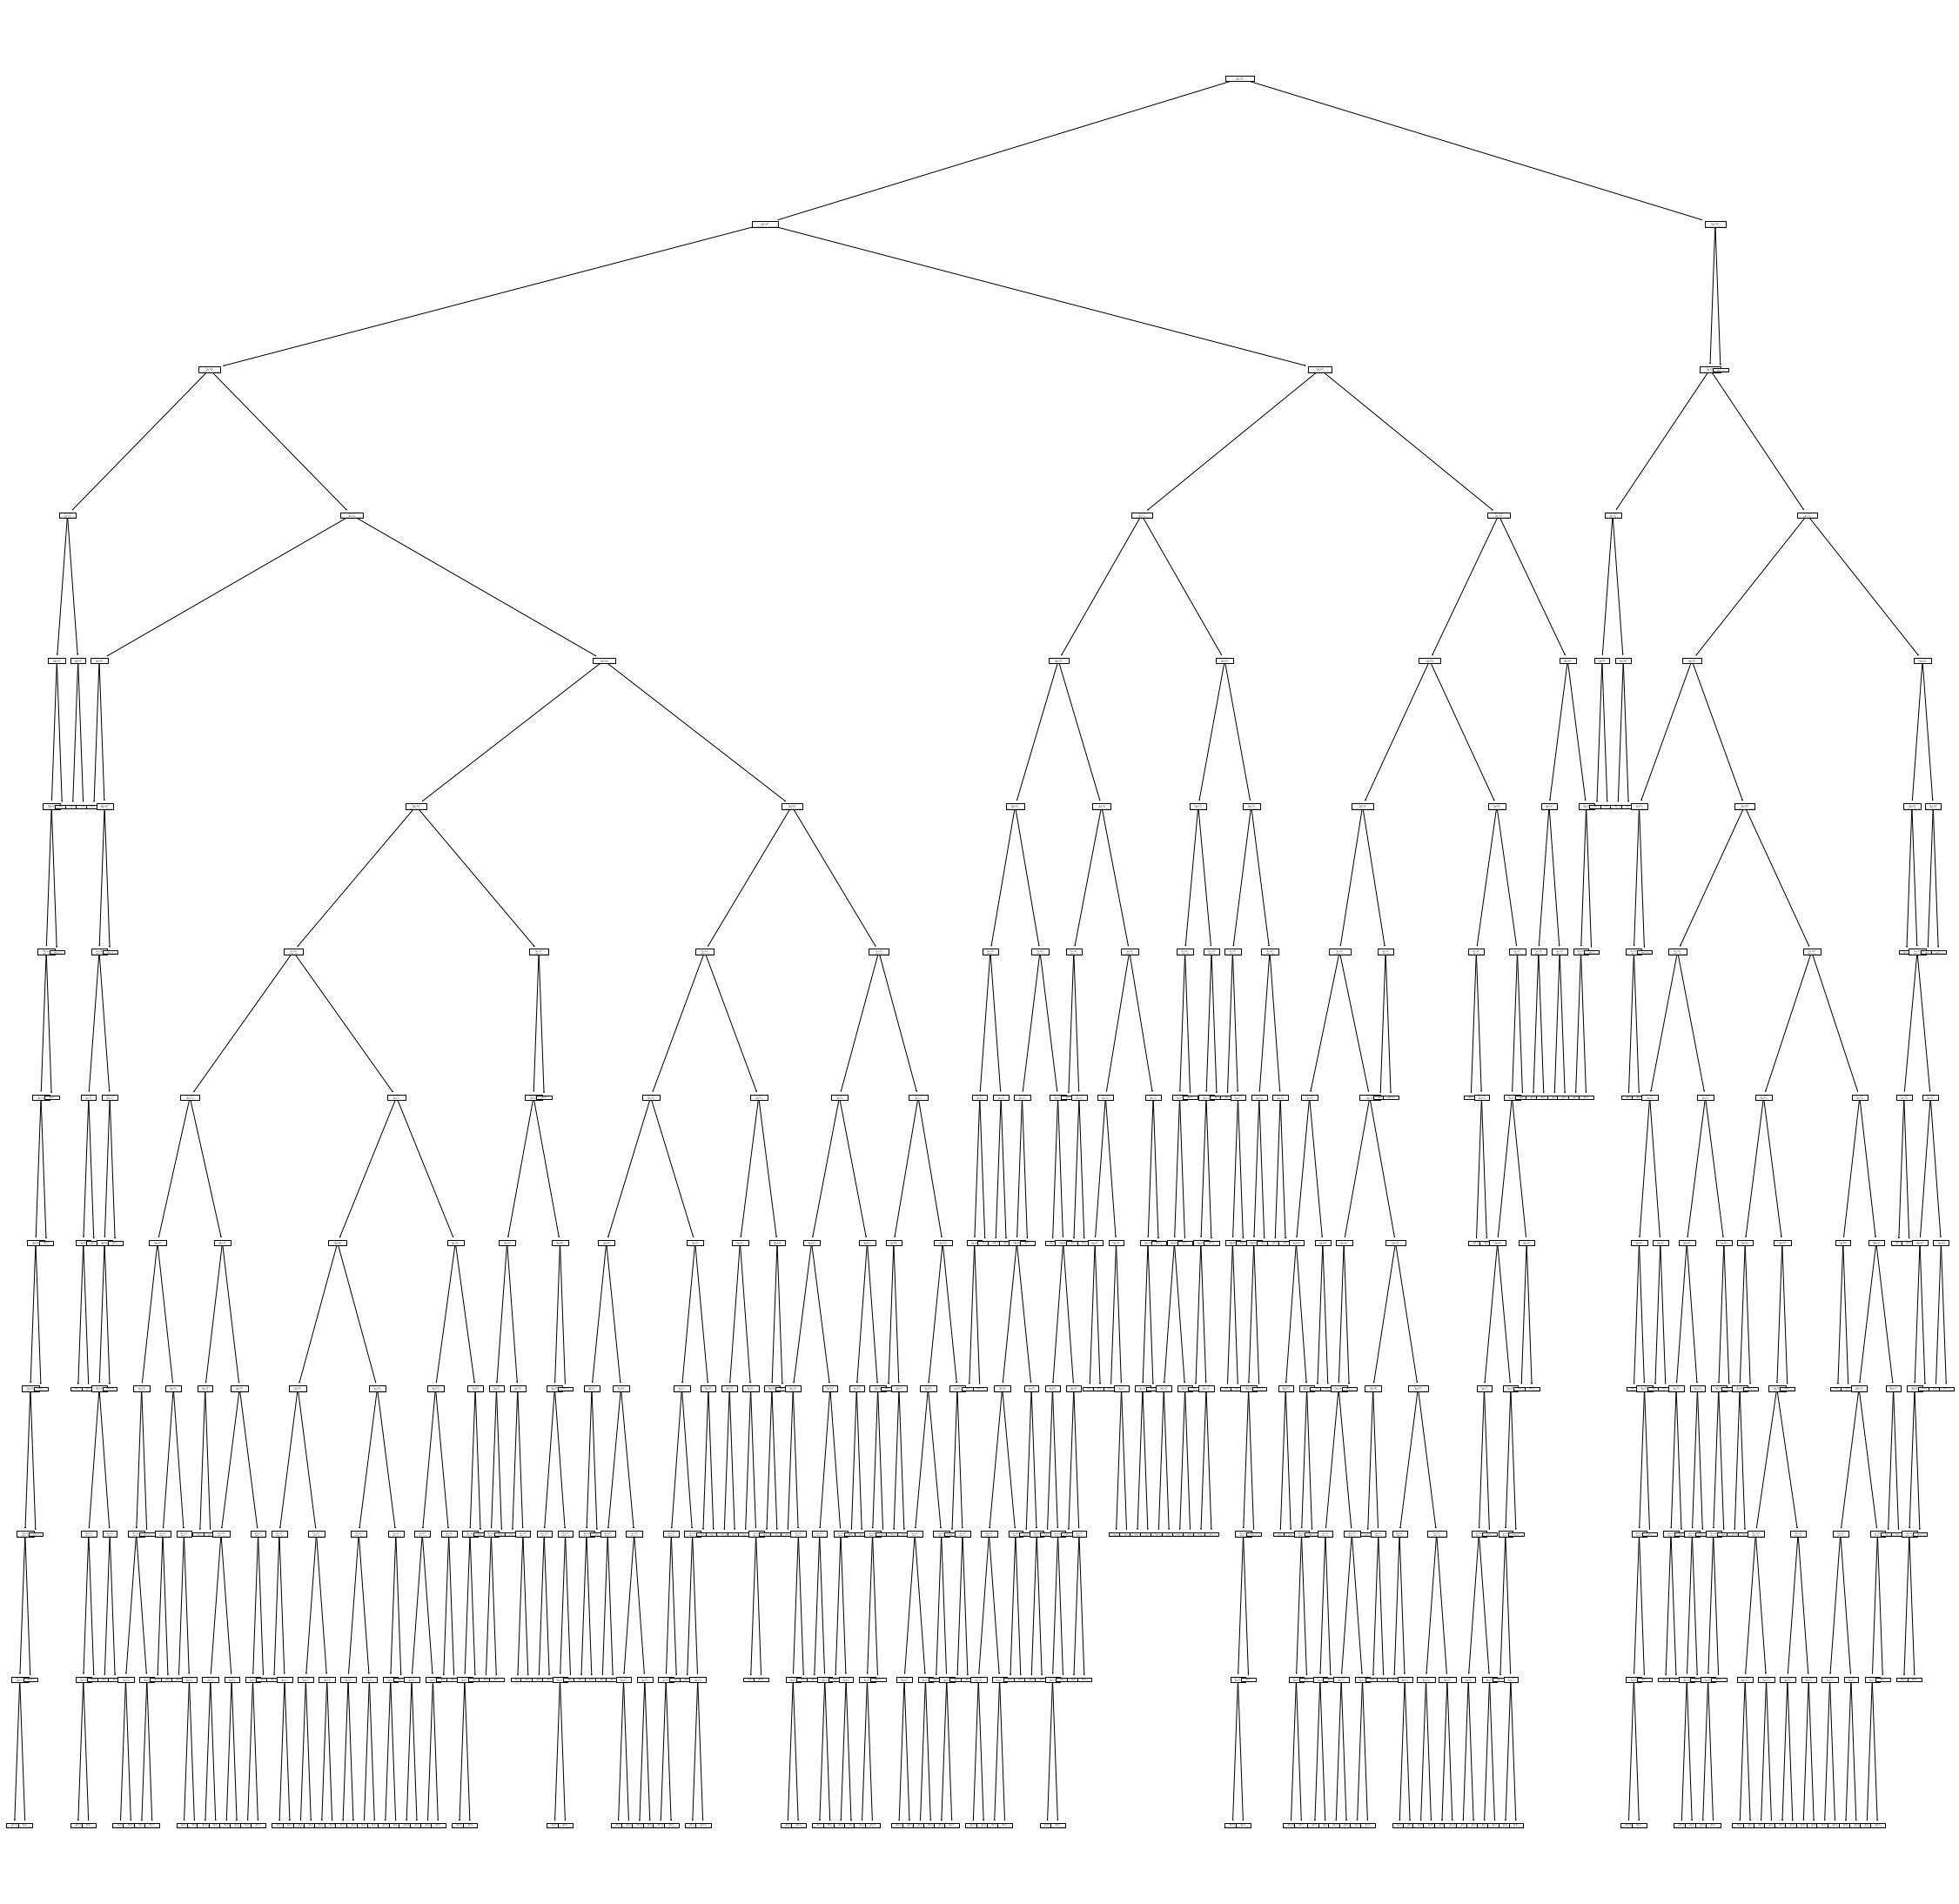

In [94]:
from sklearn import tree
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state = 123)
modelo = tree.DecisionTreeClassifier(max_depth = 12)
modelo.fit(X_train, Y_train)

Y_pred = modelo.predict(X_test)
print(metrics.accuracy_score(Y_train, modelo.predict(X_train)) * 100)
print(metrics.accuracy_score(Y_test, modelo.predict(X_test)) * 100)
print(metrics.confusion_matrix(Y_test, Y_pred))
print(metrics.accuracy_score(Y_test, Y_pred))
#print(metrics.precision_score(Y_test, Y_pred,labels='micro'))
#print(metrics.precision_score(Y_test, Y_pred,'macro'))
#print(metrics.precision_score(Y_test, Y_pred,'weighted'))
#print(metrics.precision_score(Y_test, Y_pred,'samples'))

fig, ax = plt.subplots(1, 1, figsize = (40, 40))
tree.plot_tree(modelo, 
               impurity = True#,
               #class_names = Y.unique,
               #feature_names = X.columns
              );